In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

d:\python\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def linear_function():
    np.random.seed(1)
    X = tf.constant(np.random.randn(3, 1), name = 'X')
    W = tf.constant(np.random.randn(4, 3), name = 'W')
    b = tf.constant(np.random.randn(4, 1), name = 'b')
    Y = tf.add(tf.matmul(W, X), b)
    
    sess = tf.Session()
    result = sess.run(Y)
    sess.close()
    
    return result

In [3]:
def sigmoid(z):
    x = tf.placeholder(tf.float32, name = 'x')
    sigmoid = tf.sigmoid(x)
    with tf.Session() as sess:
        result = sess.run(sigmoid, feed_dict = {x: z})
        
    return result

In [7]:
def cost(logits, labels):
    z = tf.placeholder(tf.float32, name = 'z')
    y = tf.placeholder(tf.float32, name = 'y')
    cost = tf.nn.sigmoid_cross_entropy_with_logits(logits = z, labels = y)
    
    sess = tf.Session()
    cost = sess.run(cost, feed_dict = {z: logits, y: labels})
    sess.close()
    
    return cost

In [11]:
def one_hot_matrix(labels, C):
    C = tf.constant(C, name = 'C')
    one_hot_matrix = tf.one_hot(labels, depth = C, axis = 0)
    
    with tf.Session() as sess:
        one_hot = sess.run(one_hot_matrix)
        
    return one_hot

In [16]:
def ones(shape):
    ones = tf.ones(shape)
    with tf.Session() as sess:
        ones = sess.run(ones)
        
    return ones

In [18]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

In [21]:
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

X_train = X_train_flatten / 255.
X_test = X_test_flatten / 255.

Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print("number of training examples = " + str(X_train.shape[1]))
print("number of test examples = " + str(X_test.shape[1]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


In [22]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, [n_x, None], name = 'X')
    Y = tf.placeholder(tf.float32, [n_y, None], name = 'Y')
    
    return X, Y

In [24]:
def initialize_parameters():
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1", [25,12288], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable('W2', [12,25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable('b2', [12,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable('W3', [6,12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable('b3', [6,1], initializer = tf.zeros_initializer())
    
    parameters = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    return parameters

In [25]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))

W1 = <tf.Variable 'W1:0' shape=(25, 12288) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>


In [26]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    
    return Z3

In [30]:
def compute_cost(Z3, Y):
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

In [43]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001, 
          num_epochs=1500, minibatch_size=32, print_cost=True):
    
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    costs = []
    
    X, Y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            epoch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost / num_minibatches
                
            if print_cost == True and (epoch % 100) == 0:
                print("Cost after epoch %i: %f" %(epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations per tens')
        plt.title('Learning rate = ' + str(learning_rate))
        plt.show()

        parameters = sess.run(parameters)
        print('Parameters have been trained.')

        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 1.855702
Cost after epoch 100: 1.017255
Cost after epoch 200: 0.733184
Cost after epoch 300: 0.573071
Cost after epoch 400: 0.468699
Cost after epoch 500: 0.381208
Cost after epoch 600: 0.313825
Cost after epoch 700: 0.253723
Cost after epoch 800: 0.203887
Cost after epoch 900: 0.166445
Cost after epoch 1000: 0.146664
Cost after epoch 1100: 0.107276
Cost after epoch 1200: 0.086651
Cost after epoch 1300: 0.059345
Cost after epoch 1400: 0.052250


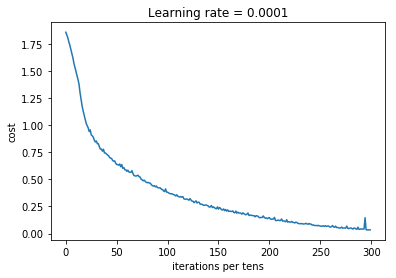

Parameters have been trained.
Train Accuracy: 0.9990741
Test Accuracy: 0.725


In [44]:
parameters = model(X_train, Y_train, X_test, Y_test)